**fine-tuner le modèle SI2M-Lab/DarijaBERT**

In [ ]:
# Installations nécessaires
!pip install transformers datasets evaluate -q
!pip install arabert -q
!pip install -q transformers datasets accelerate scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Lire le fichier depuis Drive (modifie le chemin si tu l’as mis ailleurs)
df = pd.read_csv('/content/drive/MyDrive/darija_dataset_fusionne_cleaned.csv')

# Aperçu du dataset
df.head()


,clean_text,final_label,source_langue,pays
0,موقعك يبدو أنك صاحب نظرة ثاقبة يخي تبهليل,negative,arabe,algerie
1,تبهليل هاذا,negative,arabe,algerie
2,هاذي تبهليل ماشي فهامة,negative,arabe,algerie
3,تخاف نجاوب ناصر ببلوك لانو طريقة السؤال شوي تب...,negative,arabe,algerie
4,مرنكة أقسم بالله تبهليل منتصف الليل,negative,arabe,algerie


In [ ]:
df = df[["clean_text", "final_label"]].dropna()

# Mapping des labels
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["final_label"].map(label2id)


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

In [ ]:
from transformers import AutoTokenizer

model_name = "SI2M-Lab/DarijaBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
import torch

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}
    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels)
val_dataset = TweetDataset(val_encodings, val_labels)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip uninstall transformers -y


Found existing installation: transformers 4.51.3
Uninstalling transformers-4.51.3:
  Successfully uninstalled transformers-4.51.3


In [ ]:
!pip install transformers==4.26.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 133.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.26.0 which is incompatible.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

# Configuration de l'entraînement
training_args = TrainingArguments(
    output_dir="./results",               # Répertoire de sortie
    evaluation_strategy="epoch",           # Évaluation à chaque époque
    save_strategy="epoch",                # Sauvegarde à chaque époque
    learning_rate=2e-5,                   # Taux d'apprentissage
    per_device_train_batch_size=16,       # Taille du lot par périphérique (GPU/CPU)
    per_device_eval_batch_size=16,        # Taille du lot pour l'évaluation
    num_train_epochs=4,                   # Nombre d'époques
    weight_decay=0.01,                    # Pénalité de régularisation L2
    load_best_model_at_end=True,          # Charger le meilleur modèle à la fin
    metric_for_best_model="accuracy",    # Utiliser l'accuracy pour choisir le meilleur modèle
    logging_dir="./logs",                 # Répertoire pour les logs
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

# Initialisation du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Entraînement
trainer.train()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13856
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3464
  Number of trainable parameters = 147483651
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` me

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.859700,0.753410,0.665801,0.664990
2,0.639000,0.702923,0.701010,0.700441
3,0.456500,0.727343,0.724675,0.724907
4,0.356500,0.755063,0.746320,0.746708


***** Running Evaluation *****
  Num examples = 3465
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-866
Configuration saved in ./results/checkpoint-866/config.json
Model weights saved in ./results/checkpoint-866/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-866/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-866/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3465
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-1732
Configuration saved in ./results/checkpoint-1732/config.json
Model weights saved in ./results/checkpoint-1732/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1732/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1732/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 3465
  Batch size = 16
Saving model checkpoint to ./results/checkpoint-2598
Configuration saved in ./results/checkpoint-2598/config.json


TrainOutput(global_step=3464, training_loss=0.5618309302913674, metrics={'train_runtime': 1378.7003, 'train_samples_per_second': 40.2, 'train_steps_per_second': 2.513, 'total_flos': 3645699516039168.0, 'train_loss': 0.5618309302913674, 'epoch': 4.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3465
  Batch size = 16


{'eval_loss': 0.7550633549690247,
 'eval_accuracy': 0.7463203463203463,
 'eval_f1': 0.7467082013512951,
 'eval_runtime': 22.4365,
 'eval_samples_per_second': 154.436,
 'eval_steps_per_second': 9.672,
 'epoch': 4.0}

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
import pandas as pd

# Charger les données
df = pd.read_csv('/content/drive/MyDrive/darija_dataset_fusionne_cleaned.csv')
df = df[["clean_text", "final_label"]].dropna()
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}
df["label"] = df["final_label"].map(label2id)

# Séparation train/val identique
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

# Charger tokenizer + modèle fine-tuné
model_path = "/content/drive/MyDrive/darija_bert_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# Tokenisation des textes de validation
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Création du DataLoader
class ValDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

val_dataset = ValDataset(val_encodings, val_labels)
val_loader = DataLoader(val_dataset, batch_size=16)

# Inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

preds = []
true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Rapport par classe
print("=== Rapport d'évaluation par classe ===")
print(classification_report(true_labels, preds, target_names=["negative", "neutral", "positive"]))


=== Rapport d'évaluation par classe ===
              precision    recall  f1-score   support

    negative       0.70      0.71      0.71      1206
     neutral       0.74      0.77      0.75      1172
    positive       0.81      0.76      0.79      1087

    accuracy                           0.75      3465
   macro avg       0.75      0.75      0.75      3465
weighted avg       0.75      0.75      0.75      3465



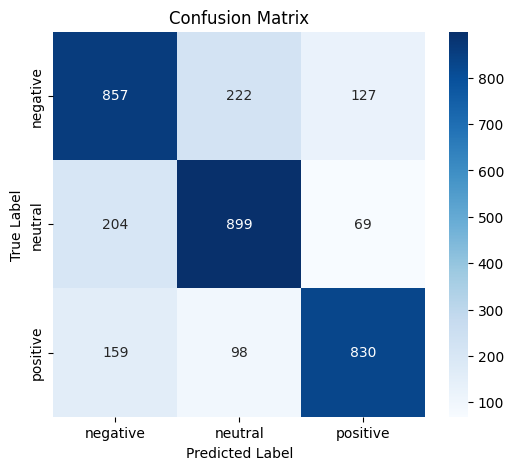

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Étiquettes
labels = ["negative", "neutral", "positive"]

# Calcul de la matrice de confusion
cm = confusion_matrix(true_labels, preds)

# Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


<ipython-input-4-9ded61387b74>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=f1_scores, palette="viridis")


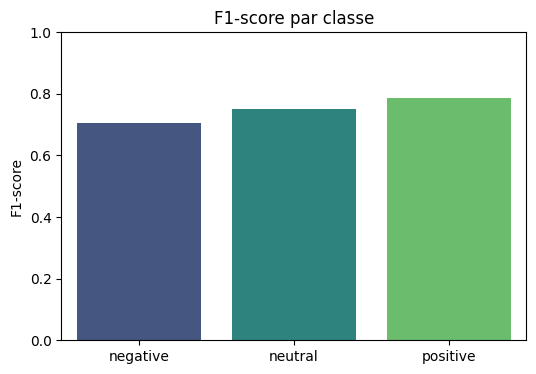

In [ ]:
from sklearn.metrics import classification_report

# Générer le rapport
report = classification_report(true_labels, preds, target_names=labels, output_dict=True)

# Extraire les F1-scores
f1_scores = [report[label]["f1-score"] for label in labels]

# Affichage
plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=f1_scores, palette="viridis")
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.title("F1-score par classe")
plt.show()


In [ ]:
from transformers import pipeline
# Créer un pipeline pour l'inférence
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Exemple
text = "had chi zwine bzaf"
result = classifier(text)
print(result)


Device set to use cuda:0


[{'label': 'positive', 'score': 0.6047075390815735}]


In [ ]:
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
text ="عجبني لباس ديالك"
result = classifier(text)
print(result)

Device set to use cuda:0


[{'label': 'positive', 'score': 0.9974028468132019}]


In [ ]:
text ="تفو عليك"
result = classifier(text)
print(result)

[{'label': 'negative', 'score': 0.9949468970298767}]


In [ ]:
text =" كريمة او اكرام كيقراو معايا"
result = classifier(text)
print(result)

[{'label': 'neutral', 'score': 0.9703172445297241}]


In [ ]:
text ="nta kalb"
result = classifier(text)
print(result)

[{'label': 'neutral', 'score': 0.4703259766101837}]


In [ ]:
# Créer un pipeline pour l'inférence
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)
text =" انا غذا غنمشي للحمام"
result = classifier(text)
print(result)

Device set to use cuda:0


[{'label': 'neutral', 'score': 0.9411734342575073}]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copier le modèle fine-tuné dans Google Drive
!cp -r ./results/checkpoint-3464 /content/drive/MyDrive/darija_bert_model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot stat './results/checkpoint-3464': No such file or directory


In [ ]:
# Charger le modèle sauvegardé depuis Google Drive
model_path = "/content/drive/MyDrive/darija_bert_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [ ]:
import pandas as pd

# Charger le fichier
df = pd.read_csv('/content/drive/MyDrive/darija_dataset_fusionne_cleaned.csv')

# Afficher les 5 premières lignes pour vérification
print(df[["clean_text", "source_langue"]].head())

# Compter combien de commentaires en arabe vs latin
print("\n📊 Statistiques des langues :")
print(df["source_langue"].value_counts())


                                          clean_text source_langue
0          موقعك يبدو أنك صاحب نظرة ثاقبة يخي تبهليل         arabe
1                                        تبهليل هاذا         arabe
2                             هاذي تبهليل ماشي فهامة         arabe
3  تخاف نجاوب ناصر ببلوك لانو طريقة السؤال شوي تب...         arabe
4                مرنكة أقسم بالله تبهليل منتصف الليل         arabe

📊 Statistiques des langues :
source_langue
latin    9316
arabe    8066
Name: count, dtype: int64


**fine-tuner le modèle SI2M-Lab/DarijaBERT-arabizi**

In [4]:
#Imports et setup
import pandas as pd
import numpy as np
import evaluate
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EvalPrediction,
)

In [1]:
!pip install numpy==1.24.4 --force-reinstall


  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.20.1 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
langchain 0.3.19 requires numpy<2,>=1.26.4; python_version < "3.12", but you have numpy 1.24.4 which is incompatible.


In [1]:
import numpy as np
print(np.__version__)  # doit afficher 1.24.4

1.24.4


In [2]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.8 MB/s eta 0:00:00


In [3]:
import evaluate
print("Evaluate imported successfully!")


Evaluate imported successfully!


In [ ]:
!pip install numpy==1.24.4 --upgrade --quiet
!pip install datasets evaluate --quiet

In [ ]:
!pip install numpy==1.24.4

In [5]:
#Désactiver Weights & Biases
os.environ["WANDB_DISABLED"] = "true"
from google.colab import drive
drive.mount('/content/drive')
#Charger le dataset
df = pd.read_csv("/content/drive/MyDrive/darija_dataset_fusionne_cleaned.csv")

#Garder les commentaires en alphabet latin
df_latin = df[df['source_langue'] == 'latin']

#Renommer les colonnes
df_latin = df_latin.rename(columns={"commentaire": "clean_text", "sentiment": "final_label"})

#Vérifier la distribution des labels
print(df_latin["final_label"].value_counts())

Mounted at /content/drive
final_label
neutral     3577
negative    3062
positive    2677
Name: count, dtype: int64


In [6]:
#Split train/test
train_df, test_df = train_test_split(
    df_latin,
    test_size=0.2,
    random_state=42,
    stratify=df_latin["final_label"]
)

#Conversion en datasets Hugging Face
dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [7]:
#Tokenizer & modèle
model_name = "SI2M-Lab/DarijaBERT-arabizi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

#Tokenisation
def tokenize_function(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/787k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at SI2M-Lab/DarijaBERT-arabizi and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7452 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

In [8]:
#Encoder les labels
label2id = {"negative": 0, "neutral": 1, "positive": 2}

def encode_labels(example):
    example["labels"] = label2id[example["final_label"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)
tokenized_test = tokenized_test.map(encode_labels)

Map:   0%|          | 0/7452 [00:00<?, ? examples/s]

Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

In [9]:
#Supprimer les colonnes inutiles
cols_to_remove = ['source_langue', 'final_label', '__index_level_0__']
for col in cols_to_remove:
    if col in tokenized_datasets.column_names:
        tokenized_datasets = tokenized_datasets.remove_columns(col)
    if col in tokenized_test.column_names:
        tokenized_test = tokenized_test.remove_columns(col)

#Ajouter les mappings de labels au modèle (optionnel mais utile)
model.config.label2id = label2id
model.config.id2label = {v: k for k, v in label2id.items()}

#Métrique d'évaluation
accuracy = evaluate.load("accuracy")

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    return accuracy.compute(predictions=preds, references=p.label_ids)

In [ ]:
#Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./darijabert_arabizi_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    report_to="none",  # <-- pour ne plus voir le warning sur wandb
)

#Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

#Entraînement
trainer.train()


The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: clean_text, pays. If clean_text, pays are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7452
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1864
  Number of trainable parameters = 170523651
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.612600,0.609075,0.748927
2,0.334700,0.519515,0.809549
3,0.239100,0.605528,0.828326
4,0.230800,0.703870,0.833155


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: clean_text, pays. If clean_text, pays are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1864
  Batch size = 8
Saving model checkpoint to ./darijabert_arabizi_finetuned/checkpoint-466
Configuration saved in ./darijabert_arabizi_finetuned/checkpoint-466/config.json
Model weights saved in ./darijabert_arabizi_finetuned/checkpoint-466/pytorch_model.bin
tokenizer config file saved in ./darijabert_arabizi_finetuned/checkpoint-466/tokenizer_config.json
Special tokens file saved in ./darijabert_arabizi_finetuned/checkpoint-466/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: clean_text, pays. If clean_text, pays are not expected by `Bert

TrainOutput(global_step=1864, training_loss=0.3955055001979222, metrics={'train_runtime': 375.027, 'train_samples_per_second': 79.482, 'train_steps_per_second': 4.97, 'total_flos': 530333871460848.0, 'train_loss': 0.3955055001979222, 'epoch': 4.0})

Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

=== Rapport d'évaluation par classe ===
              precision    recall  f1-score   support

    negative       0.80      0.77      0.79       613
     neutral       0.81      0.84      0.82       716
    positive       0.90      0.90      0.90       535

    accuracy                           0.83      1864
   macro avg       0.84      0.84      0.84      1864
weighted avg       0.83      0.83      0.83      1864



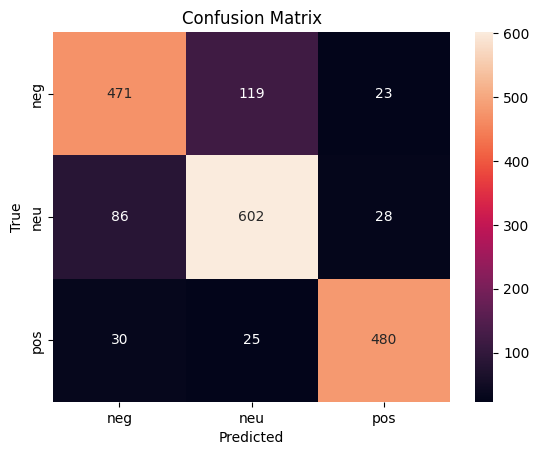

In [10]:
# Imports
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset

# Charger le modèle et tokenizer fine-tunés
model_path = "/content/drive/MyDrive/darijabert_arabizi_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# Mettre sur le bon device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 1. Garder uniquement les colonnes utiles
test_df = test_df[["clean_text", "final_label"]]  # Important

# 2. Reconvertir en Hugging Face Dataset
test_dataset = Dataset.from_pandas(test_df)

# 3. Tokeniser avec padding dynamique (pas besoin de max_length ici)
def tokenize_function(example):
    return tokenizer(example["clean_text"], padding=True, truncation=True)

tokenized_test = test_dataset.map(tokenize_function, batched=True)

# 4. Encoder les labels
label2id = {"negative": 0, "neutral": 1, "positive": 2}

def encode_labels(example):
    example["labels"] = label2id[example["final_label"]]
    return example

tokenized_test = tokenized_test.map(encode_labels)

# 5. Supprimer les colonnes inutiles
cols_to_remove = ['final_label', '__index_level_0__']
for col in cols_to_remove:
    if col in tokenized_test.column_names:
        tokenized_test = tokenized_test.remove_columns(col)

# 6. Format torch (ne pas inclure les labels si collate_fn les gère déjà)
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# 7. Collateur dynamique
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
test_loader = DataLoader(tokenized_test, batch_size=16, collate_fn=data_collator)

# 8. Évaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 9. Rapport d'évaluation
print("=== Rapport d'évaluation par classe ===")
print(classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"]))

# 10. Matrice de confusion (optionnel)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["neg", "neu", "pos"], yticklabels=["neg", "neu", "pos"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


<ipython-input-12-2b6ce4a2ad84>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")


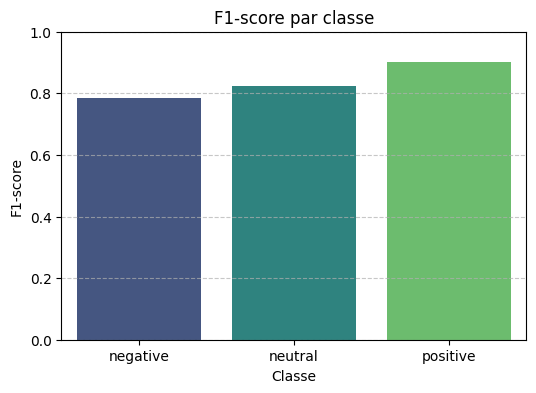

In [12]:
# Extraire les scores de classification_report sous forme de dictionnaire
report_dict = classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"], output_dict=True)

# Extraire les F1-scores
f1_scores = {label: report_dict[label]["f1-score"] for label in ["negative", "neutral", "positive"]}

# Tracer le graphe des F1-scores
plt.figure(figsize=(6, 4))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="viridis")
plt.ylim(0, 1)
plt.title("F1-score par classe")
plt.xlabel("Classe")
plt.ylabel("F1-score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
!pip install numpy==1.24.4

In [ ]:
#Créer un dossier dans Drive
save_path = "/content/drive/MyDrive/darijabert_arabizi_finetuned"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


Configuration saved in /content/drive/MyDrive/darijabert_arabizi_finetuned/config.json
Model weights saved in /content/drive/MyDrive/darijabert_arabizi_finetuned/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/darijabert_arabizi_finetuned/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/darijabert_arabizi_finetuned/special_tokens_map.json


('/content/drive/MyDrive/darijabert_arabizi_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/darijabert_arabizi_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/darijabert_arabizi_finetuned/vocab.txt',
 '/content/drive/MyDrive/darijabert_arabizi_finetuned/added_tokens.json',
 '/content/drive/MyDrive/darijabert_arabizi_finetuned/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Charger le modèle fine-tuné depuis Google Drive
model_path = "/content/drive/MyDrive/darijabert_arabizi_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Dictionnaire pour interpréter la sortie
id2label = {0: "negative", 1: "neutral", 2: "positive"}

In [ ]:
def predict_sentiment(comment):
    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    return id2label[predicted_class_id]

In [ ]:
predict_sentiment("gha mjmo3at lkadabin had lhokoma")

'negative'

**les deux modeles**

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re

#Charger les deux modèles et leurs tokenizers ---
model_ar_path = "/content/drive/MyDrive/darija_bert_model"      #(arabe)
model_lat_path = "/content/drive/MyDrive/darijabert_arabizi_finetuned" #(latin)

tokenizer_ar = AutoTokenizer.from_pretrained(model_ar_path)
model_ar = AutoModelForSequenceClassification.from_pretrained(model_ar_path)

tokenizer_lat = AutoTokenizer.from_pretrained(model_lat_path)
model_lat = AutoModelForSequenceClassification.from_pretrained(model_lat_path)

#Dictionnaire des labels
id2label = {0: "negative", 1: "neutral", 2: "positive"}


In [ ]:
def detect_script(text):
    # Si le texte contient une lettre arabe (unicode arabe)
    if re.search(r'[\u0600-\u06FF]', text):
        return 'arabic'
    else:
        return 'latin'

In [ ]:
def predict_sentiment_auto(comment):
    script = detect_script(comment)

    if script == 'arabic':
        model = model_ar
        tokenizer = tokenizer_ar
    else:
        model = model_lat
        tokenizer = tokenizer_lat

    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1).squeeze().tolist()

    predicted_class_id = torch.argmax(logits).item()
    predicted_label = id2label[predicted_class_id]
    scores = {id2label[i]: round(probs[i], 4) for i in range(len(probs))}

    return predicted_label, scores, script


In [ ]:
commentaire = "  نتي تيتيزا"
#commentaire = "nta kalb"

label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)


Langue détectée : arabic
Sentiment prédit : positive
Scores : {'negative': 0.0056, 'neutral': 0.0098, 'positive': 0.9846}


In [ ]:
commentaire = "واش نتي مريضة فراسك"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : arabic
Sentiment prédit : negative
Scores : {'negative': 0.9956, 'neutral': 0.0027, 'positive': 0.0017}


In [ ]:
commentaire = "ليوما متغديتش"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : arabic
Sentiment prédit : neutral
Scores : {'negative': 0.011, 'neutral': 0.9794, 'positive': 0.0096}


In [ ]:
commentaire ="ma3ndich m3ak"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : latin
Sentiment prédit : negative
Scores : {'negative': 0.9867, 'neutral': 0.0124, 'positive': 0.001}


In [ ]:
commentaire = "ma3jbnich had l music"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : latin
Sentiment prédit : negative
Scores : {'negative': 0.9882, 'neutral': 0.0102, 'positive': 0.0016}


In [ ]:
commentaire = "jiti bomba"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : latin
Sentiment prédit : positive
Scores : {'negative': 0.0005, 'neutral': 0.0004, 'positive': 0.9991}


In [ ]:
commentaire = "jiti ki chi bagra"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : latin
Sentiment prédit : negative
Scores : {'negative': 0.9886, 'neutral': 0.0106, 'positive': 0.0008}


In [ ]:
commentaire = "lah insar sidna"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : latin
Sentiment prédit : positive
Scores : {'negative': 0.0017, 'neutral': 0.0006, 'positive': 0.9977}


In [ ]:
commentaire = "lah ighabar lik ch9af"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : latin
Sentiment prédit : negative
Scores : {'negative': 0.9853, 'neutral': 0.0139, 'positive': 0.0008}


In [ ]:
commentaire = "lah ighasbak"
label, score_dict, script = predict_sentiment_auto(commentaire)

print("Langue détectée :", script)
print("Sentiment prédit :", label)
print("Scores :", score_dict)

Langue détectée : latin
Sentiment prédit : negative
Scores : {'negative': 0.9832, 'neutral': 0.0157, 'positive': 0.0011}


In [ ]:
# --- 1. Importations ---
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
import nltk
from nltk.tokenize import PunktSentenceTokenizer

# --- 2. Téléchargement des ressources NLTK ---
nltk.download('punkt')

# --- 3. Monter Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 4. Chemins vers les modèles (dans Google Drive) ---
model_ar_path = "/content/drive/MyDrive/darija_bert_model"  # Arabe
model_lat_path = "/content/drive/MyDrive/darijabert_arabizi_finetuned"  # Latin

# --- 5. Chargement des modèles et tokenizers ---
tokenizer_ar = AutoTokenizer.from_pretrained(model_ar_path)
model_ar = AutoModelForSequenceClassification.from_pretrained(model_ar_path)

tokenizer_lat = AutoTokenizer.from_pretrained(model_lat_path)
model_lat = AutoModelForSequenceClassification.from_pretrained(model_lat_path)

# --- 6. Dictionnaire des labels ---
id2label = {0: "negative", 1: "neutral", 2: "positive"}

# --- 7. Détection du script dominant ---
def detect_script(text):
    if re.search(r'[\u0600-\u06FF]', text):  # caractères arabes
        return 'arabic'
    else:
        return 'latin'

# --- 8. Prédiction du sentiment automatique ---
def predict_sentiment_auto(comment):
    script = detect_script(comment)

    if script == 'arabic':
        model = model_ar
        tokenizer = tokenizer_ar
    else:
        model = model_lat
        tokenizer = tokenizer_lat

    inputs = tokenizer(comment, return_tensors="pt", truncation=True, padding=True)

    with torch.no_grad():
        logits = model(**inputs).logits
        probs = F.softmax(logits, dim=1).squeeze().tolist()

    predicted_class_id = torch.argmax(logits).item()
    predicted_label = id2label[predicted_class_id]
    scores = {id2label[i]: round(probs[i], 4) for i in range(len(probs))}

    return predicted_label, scores, script

# --- 9. Analyse de commentaires complexes ---
def analyze_complex_comment(comment):
    # Séparation selon les conjonctions usuelles (darija, français)
    parts = re.split(r'\b(?:walakin|mais|ولكن|w|o)\b', comment, flags=re.IGNORECASE)

    for i, part in enumerate(parts):
        part = part.strip()
        if part:
            label, scores, script = predict_sentiment_auto(part)
            print(f"Partie {i+1}: [{label.upper()} - {scores[label]}] (script: {script}) → {part}")

# --- 10. Exemple d'utilisation ---
commentaire = "الخدمة زوينة بزاف. Mais le prix est trop élevé."
analyze_complex_comment(commentaire)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Partie 1: [POSITIVE - 0.9876] (script: arabic) → الخدمة زوينة بزاف.
Partie 2: [NEUTRAL - 0.7687] (script: latin) → le prix est trop élevé.


**finetune le model UBC-NLP/MARBERTv2**

In [ ]:
# Installation
!pip install datasets evaluate

In [ ]:
# Imports
import pandas as pd
import numpy as np
import evaluate
import os
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EvalPrediction,
)

# Désactiver Weights & Biases
os.environ["WANDB_DISABLED"] = "true"

# Monter Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Charger le dataset
df = pd.read_csv("/content/drive/MyDrive/darija_dataset_fusionne_cleaned.csv")
df_latin = df[df['source_langue'] == 'latin']
df_latin = df_latin.rename(columns={"commentaire": "clean_text", "sentiment": "final_label"})
print(df_latin["final_label"].value_counts())

# Split train/test
train_df, test_df = train_test_split(
    df_latin,
    test_size=0.2,
    random_state=42,
    stratify=df_latin["final_label"]
)

# Convertir en datasets Hugging Face
dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizer & modèle
model_name = "UBC-NLP/MARBERTv2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Tokenisation
def tokenize_function(example):
    return tokenizer(example["clean_text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Encoder les labels
label2id = {"negative": 0, "neutral": 1, "positive": 2}
def encode_labels(example):
    example["labels"] = label2id[example["final_label"]]
    return example

tokenized_datasets = tokenized_datasets.map(encode_labels)
tokenized_test = tokenized_test.map(encode_labels)

# Supprimer colonnes inutiles
cols_to_remove = ['source_langue', 'final_label', '__index_level_0__']
for col in cols_to_remove:
    if col in tokenized_datasets.column_names:
        tokenized_datasets = tokenized_datasets.remove_columns(col)
    if col in tokenized_test.column_names:
        tokenized_test = tokenized_test.remove_columns(col)

# Ajouter mappings label2id au modèle
model.config.label2id = label2id
model.config.id2label = {v: k for k, v in label2id.items()}

# Charger les métriques
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_macro = f1.compute(predictions=preds, references=p.label_ids, average="macro")
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_macro["f1"]
    }

# Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./marbetv2_finetuned",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2,
    report_to="none",
)

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Entraînement
trainer.train()

# Sauvegarde sur Drive
save_path = "/content/drive/MyDrive/marbetv2_finetuned"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


0it [00:00, ?it/s]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
final_label
neutral     3577
negative    3062
positive    2677
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at UBC-NLP/MARBERTv2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if

Map:   0%|          | 0/7452 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Map:   0%|          | 0/7452 [00:00<?, ? examples/s]

Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: clean_text, pays. If clean_text, pays are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7452
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1864
  Number of trainable parameters = 162843651
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is 

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.959300,0.917638,0.567597,0.568360
2,0.781600,0.866589,0.622318,0.623946
3,0.760900,0.788669,0.657189,0.660212
4,0.563900,0.793767,0.672747,0.676521


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: clean_text, pays. If clean_text, pays are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1864
  Batch size = 8
Saving model checkpoint to ./marbetv2_finetuned/checkpoint-466
Configuration saved in ./marbetv2_finetuned/checkpoint-466/config.json
Model weights saved in ./marbetv2_finetuned/checkpoint-466/pytorch_model.bin
tokenizer config file saved in ./marbetv2_finetuned/checkpoint-466/tokenizer_config.json
Special tokens file saved in ./marbetv2_finetuned/checkpoint-466/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: clean_text, pays. If clean_text, pays are not expected by `BertForSequenceClassification.forward`,  you can safel

('/content/drive/MyDrive/marbetv2_finetuned/tokenizer_config.json',
 '/content/drive/MyDrive/marbetv2_finetuned/special_tokens_map.json',
 '/content/drive/MyDrive/marbetv2_finetuned/vocab.txt',
 '/content/drive/MyDrive/marbetv2_finetuned/added_tokens.json',
 '/content/drive/MyDrive/marbetv2_finetuned/tokenizer.json')

Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1864 [00:00<?, ? examples/s]

=== Rapport d'évaluation par classe ===
              precision    recall  f1-score   support

    negative       0.59      0.69      0.63       613
     neutral       0.69      0.67      0.68       716
    positive       0.79      0.66      0.72       535

    accuracy                           0.67      1864
   macro avg       0.69      0.67      0.68      1864
weighted avg       0.68      0.67      0.67      1864



<ipython-input-13-02513ea9778d>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")


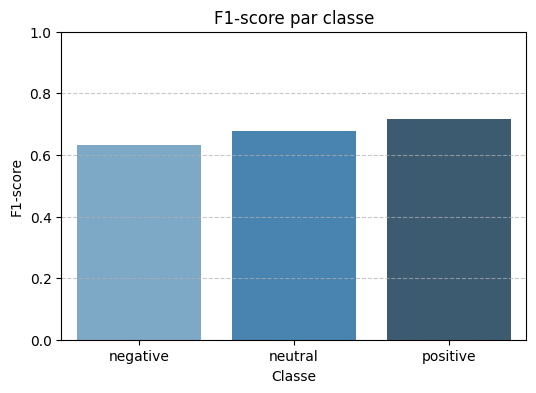

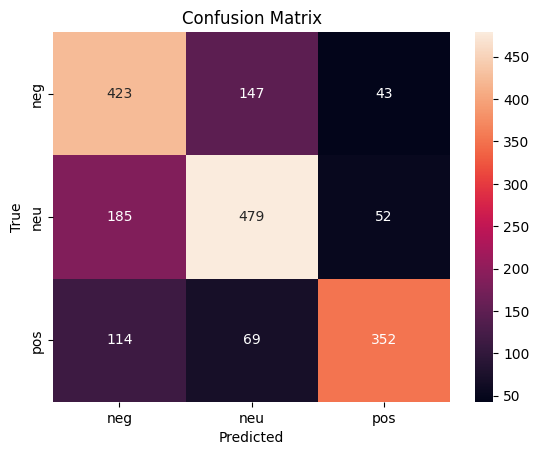

In [13]:
# Imports nécessaires
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset

# Recharger le modèle et le tokenizer fine-tunés
model_path = "/content/drive/MyDrive/marbetv2_finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# Envoyer sur GPU si dispo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Nettoyage du test dataframe
test_df = test_df[["clean_text", "final_label"]]

# Reconvertir en dataset Hugging Face
test_dataset = Dataset.from_pandas(test_df)

# Tokenisation dynamique
def tokenize_function(example):
    return tokenizer(example["clean_text"], padding=True, truncation=True)

tokenized_test = test_dataset.map(tokenize_function, batched=True)

# Encoder les labels
label2id = {"negative": 0, "neutral": 1, "positive": 2}
def encode_labels(example):
    example["labels"] = label2id[example["final_label"]]
    return example

tokenized_test = tokenized_test.map(encode_labels)

# Supprimer colonnes inutiles
cols_to_remove = ['final_label', '__index_level_0__']
for col in cols_to_remove:
    if col in tokenized_test.column_names:
        tokenized_test = tokenized_test.remove_columns(col)

# Format torch
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
test_loader = DataLoader(tokenized_test, batch_size=16, collate_fn=data_collator)

# Évaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Rapport de classification
print("=== Rapport d'évaluation par classe ===")
report = classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"])
print(report)

# Graphe des F1-score par classe
report_dict = classification_report(all_labels, all_preds, target_names=["negative", "neutral", "positive"], output_dict=True)
f1_scores = {label: report_dict[label]["f1-score"] for label in ["negative", "neutral", "positive"]}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Blues_d")
plt.ylim(0, 1)
plt.title("F1-score par classe")
plt.xlabel("Classe")
plt.ylabel("F1-score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Matrice de confusion (facultatif)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["neg", "neu", "pos"], yticklabels=["neg", "neu", "pos"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
